# Model assessment: LOO-CV for factory data with Stan (6p)
Use leave-one-out cross validation (LOO-CV) to assess the predictive performance of the pooled, separate and hierarchical Gaussian models for the factory dataset (see the second exercise in As- signment 6). Use Stan for fitting the models, and the provided PSIS-LOO (Pareto smoothed impor- tance sampling LOO) code for computing the approximate LOO-CV given the posterior samples provided by Stan. Your results should include:
- PSIS-LOO values, the effective number of parameters $p_{eff}$, and the k-values for each of the three models
- an assessment of how reliable the PSIS-LOO estimates are for the three models based on the k-values
- an assessment of whether there are differences between the models, and if so, which model should be selected according to PSIS-LOO

![psis-loo](images/psis-loo.png)

![k-values](images/k-values.png)

![p_eff](images/p_eff.png)

## An assessment of how reliable the PSIS-LOO estimates are for the three models based on the k-values

According to the plot above, "k-values for three different models", separate model has high k-values which go over 0.7. Thus Separate model's PSIS-LOO estimates can be considered as unreliable. On the other hand, pooled and hierarchical models may be considered as reliable. Among the two, the pooled may be considered most reliable.


## An assessment of whether there are differences between the models, and if so, which model should be selected according to PSIS-LOO

Look at the graph, "$p_{eff}$(number of effective parameters) for three different models", and one can see the three models have different $p_{eff}$ values. The seperated model has the highest $p_{eff}$ being the most complex model and the pooled the least.

The hierarchical model has the highest PSIS-LOO and it doesn't have any observation where k-value is over 0.7. Thus the hierarchical model is considered reliable and better choice than the others.

# Appendix

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
import seaborn as sns

from scipy.stats import distributions

import pickle

# add utilities directory to path
import os, sys
util_path = os.path.abspath('utilities_and_data')
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import stan_utility
import stan_helper

import pystan
from IPython.display import Image

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)


In [3]:
from psis import psisloo

In [4]:
def get_stan_model(model_name, model_code, get_new=False):
    path = os.path.abspath(os.path.join(os.path.curdir, model_name))

    if not get_new and os.path.exists(path):
        print("Model exists already! Returning pickle.")
        return pickle.load(open(path, 'rb'))
    
    print("Path doesn't exist. Compiling model. It might take few minutes...")
    import pystan
    sm = pystan.StanModel(model_code=model_code)
    with open(model_name, 'wb') as f:
        pickle.dump(sm, f)
    return sm


Load model

In [5]:
d = np.loadtxt("data/factory.txt")

## (1). Separate model with unequal standard deviations

$$ y_{i,m} = \alpha_m + \beta_m \times \text{machine}_{i,m} + \epsilon_m $$

- $i$: measurement index
- $m$: machine being measured

$\epsilon$ is an error term sampled from $N(\mu, \sigma_\epsilon)$

Here we say that all six machines are completely different with no similarities. Based on this model we won't be able to predict another machine.

In [6]:
x = np.tile(np.arange(1, 7), d.shape[0])
y = d.ravel();y
N = len(x)
data = dict(
    N = N,
    K = 6,  # 6 machines
    x = x,  # group indicators
    y = y,   # observations
    target_machine = 5  # 6th machine
)

data_code = '''
data {
  int<lower=0> N; // number of data points
  int<lower=0> K; // number of groups
  int<lower=1,upper=K> x[N]; // group indicator
  vector[N] y; //
  int<lower=0> target_machine;
}
parameters {
  vector[K] mu;        // group means
  vector<lower=0>[K] sigma; // group stds
}
model {
    y ~ normal(mu[x], sigma[x]);
}

generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(mu[target_machine], sigma[target_machine]);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma[x[i]]);
}
'''

In [7]:
# sm_separate = get_stan_model('factory_model.pkl', data_code, get_new=True)
sm_separate = get_stan_model('factory_model.pkl', data_code)

fit_separate = sm_separate.sampling(data=data, seed=194838);

# Extract samples in different forms for different parameters.
# permuted : bool
#    If True, returned samples are permuted. All chains are
#    merged and warmup samples are discarded.
samples_separate = fit_separate.extract(permuted=True)

log_likelihood = samples_separate['log_lik'];

Model exists already! Returning pickle.


*log_likelihood* is an S-by-n matrix, where S is the number of posterior draws and n = 30 is the total number of observations

In [8]:
log_likelihood.shape

(4000, 30)

In [9]:
'''
Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces
'''
loo_separate, loos, ks_separate = psisloo(log_likelihood)

## PSIS-LOO values, the effective number of parameters peff, and the k-values for each of the three models

$$ p_{loo-cv} = lppd - lppd_{loo-cv} $$

The **estimated effective number of parameters** in the model can be computed from equation (7.15) in the book, where $lppd_{loo-cv}$ is the PSIS-LOO value (sum of the LOO log densi- ties) and lppd is given by equation (7.5) in the book.

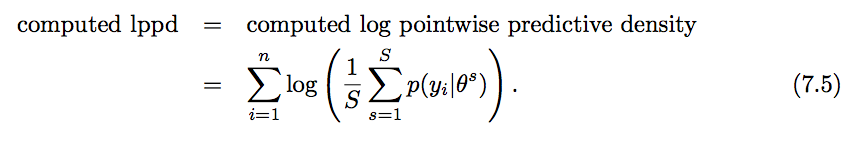

In [10]:
Image(filename='images/computed_llpd.png',height=150,width=600)

In [11]:
S, n = log_likelihood.shape # 4000, 30
print("S:{}, n:{}".format(S, n))
# llpd_separate = np.log(
#     np.exp(
#         log_likelihood
#     ).sum(axis=0) # Sum over columns
#     / S
# ).sum()
llpd_separate = np.sum(log_likelihood / S)

print("llpd: {}, llpd-cv: {}".format(llpd_separate, loo_separate))

S:4000, n:30
llpd: -125.9605095224196, llpd-cv: -131.82621693016765


## Assessment of how reliable the PSIS-LOO estimates are for the three models based on the k-values

/Users/seyoung/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


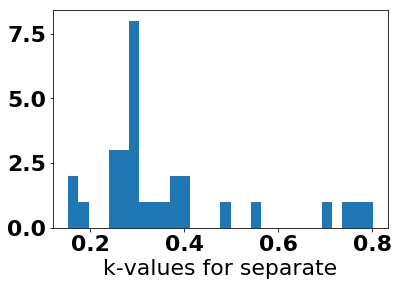

In [12]:
plt.hist(ks_separate, 30)
plt.xlabel("k-values for separate")

## (2). Pooled model

$$ y_{i,m} = \alpha + \beta \times \text{machine}_{i,m} + \epsilon_m $$

- $i$: measurement index
- $m$: machine being measured

$\epsilon$ is an error term sampled from $N(\mu, \sigma_\epsilon)$

So here we are aggregating all the machines into a single machines as they are __exactly__ the same.

In [13]:
# Gaussian linear model with uniform priors
pooling_code = """
data {
  int<lower=0> N; // number of data points
  vector[N] y; //
}
parameters {
  real mu;        // group means
  real<lower=0> sigma; // common std
}
model {
  y ~ normal(mu, sigma);
}
generated quantities {
  real ypred;
  vector[N] log_lik;
  ypred = normal_rng(mu, sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu, sigma);
}
"""

In [14]:
# sm_pooled = get_stan_model("factory_pooling_posterior", pooling_code, get_new=True)
sm_pooled = get_stan_model("factory_pooling_posterior", pooling_code)

Model exists already! Returning pickle.


Pool all the observations. I don't know how to not to use vectors so treat this as observations of 1 machine

In [15]:
x = np.full(1, 1)
y = d.ravel();y
N = len(y)
data = dict(
    N = N,
    y = y   # observations
)

In [16]:
fit_pooled = sm_pooled.sampling(data=data, seed=194838)

In [17]:
samples_pooled = fit_pooled.extract(permuted=True)

In [18]:
log_likelihood_pooled = samples_pooled['log_lik'];

*log_likelihood* is an S-by-n matrix, where S is the number of posterior draws and n = 30 is the total number of observations

In [19]:
log_likelihood_pooled.shape

(4000, 30)

In [20]:
'''
Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces
'''
loo_pooled, loos, ks_pooled = psisloo(log_likelihood_pooled)

S, n = log_likelihood_pooled.shape # 4000, 30
print("S:{}, n:{}".format(S, n))
# llpd_pooled = np.log(
#     np.exp(
#         log_likelihood
#     ).sum(axis=0) # Sum over columns
#     / S
# ).sum()
llpd_pooled = np.sum(log_likelihood_pooled / S)
print("llpd: {}, llpd-cv: {}".format(llpd_pooled, loo_pooled))

S:4000, n:30
llpd: -129.8609217183282, llpd-cv: -130.99344999235734


/Users/seyoung/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


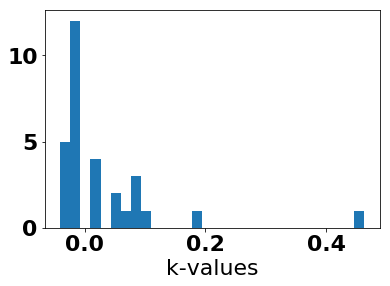

In [21]:
plt.hist(ks_pooled, 30)
plt.xlabel("k-values")

## (3) hierarchical model

Hierarchical modeling is a statistically rigorous way to make scientific inferences about a population based on many groups/observations. Humanly speaking, it's a middle ground between pooling and separate modeling. We will have the same formula as separate:

$$ y_{i,m} = \alpha_m + \beta_m \times \text{machine}_{i,m} + \epsilon_m $$

But $\alpha$ and $\beta$ come from a common group distribution:

$$\alpha_{c} \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{c} \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)$$

So we model coefficients and predictions. That's why it's called hierarchical/multilevel modeling.

In [22]:
x = np.tile(np.arange(1, 7), d.shape[0])
y = d.ravel();y
N = len(x)
data = dict(
    N = N,
    K = 7,  # 6 machines
    x = x,  # group indicators
    y = y,   # observations
    target_machine = 5  # 6th machine
)

Our linear model:
$$ y = \beta_0 + \beta_1 \times x + e $$

$e$ is an error term sampled from $N(\mu, \sigma)$

Priors for each machine is not fixed, but rather depend on other latent variables.

In [23]:
#  Comparison of k groups with common variance and
#  hierarchical prior for the mean

data_code = '''
data {
    int<lower=0> N; // number of data points
    int<lower=0> K; // number of groups
    int<lower=1,upper=K> x[N]; // group indicator
    vector[N] y; //
    int<lower=0> target_machine;
}
parameters {
    real<lower=70, upper=110> mu0; // uniform prior mean
    real<lower=0, upper=20> sigma0; // uniform prior std
    vector[K] mu;         // group means
    real<lower=0> sigma;  // common std
}
model {
  mu ~ normal(mu0, sigma0); // population prior with unknown parameters
  y ~ normal(mu[x], sigma);
  //for (i in 1:N)
  //mu7 ~ normal(mu0, sigma0);  // Is this correct? Idk. mu7 ~ normal(mu0, sigma0) gave me low mean around 19.
}
generated quantities {
  real ypred;
  real mu7;
  real ypred7;
  vector[N] log_lik;
  ypred = normal_rng(mu[target_machine], sigma);
  for (i in 1:N)
    log_lik[i] = normal_lpdf(y[i] | mu[x[i]], sigma);
    
  mu7 = normal_rng(mu0,sigma0);
  ypred7 = normal_rng(mu7, sigma);

}
'''

In [24]:
# sm_hierarchical =  get_stan_model("factory_hierarchical_posterior", data_code, get_new=True)
sm_hierarchical =  get_stan_model("factory_hierarchical_posterior", data_code)

Model exists already! Returning pickle.


In [25]:
fit_hierarchical = sm_hierarchical.sampling(data=data, seed=194838);

In [26]:
# Extract samples in different forms for different parameters.
# permuted : bool
#    If True, returned samples are permuted. All chains are
#    merged and warmup samples are discarded.
samples_hierarchical = fit_hierarchical.extract(permuted=True)

# stan_utility.check_treedepth(fit_hierarchical)
# stan_utility.check_energy(fit_hierarchical)
# stan_utility.check_div(fit_hierarchical)

In [27]:
log_likelihood_hierarchical = samples_hierarchical['log_lik'];

*log_likelihood* is an S-by-n matrix, where S is the number of posterior draws and n = 30 is the total number of observations

In [28]:
log_likelihood_hierarchical.shape

'''
Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces
'''
loo_hierarchical, loos_hier, ks_hierarchical = psisloo(log_likelihood_hierarchical)

S, n = log_likelihood_hierarchical.shape # 4000, 30
print("S:{}, n:{}".format(S, n))
# llpd_hierarchical = np.log(
#     np.exp(
#         log_likelihood
#     ).sum(axis=0) # Sum over columns
#     / S
# ).sum()
llpd_hierarchical = np.sum(log_likelihood_hierarchical / S)
print("llpd: {}, llpd-cv: {}".format(llpd_hierarchical, loo_hierarchical))

S:4000, n:30
llpd: -123.54082718554642, llpd-cv: -126.79353008133994


## PSIS-LOO values, the effective number of parameters peff, and the k-values for each of the three models

/Users/seyoung/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


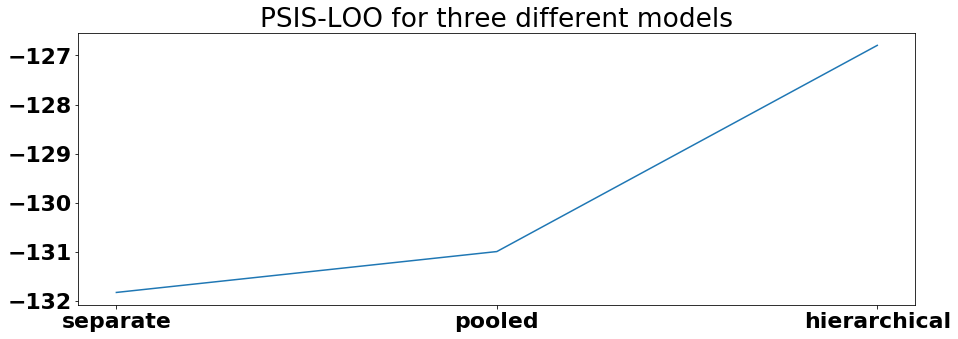

In [29]:
Y = [loo_separate,loo_pooled, loo_hierarchical]
X = list(range(3))
Xticks = ["separate", 'pooled', "hierarchical"]
plt.figure(figsize=(15,5))
plt.title(r"PSIS-LOO for three different models")
plt.xticks(X, Xticks)
plt.plot(X, Y)

/Users/seyoung/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


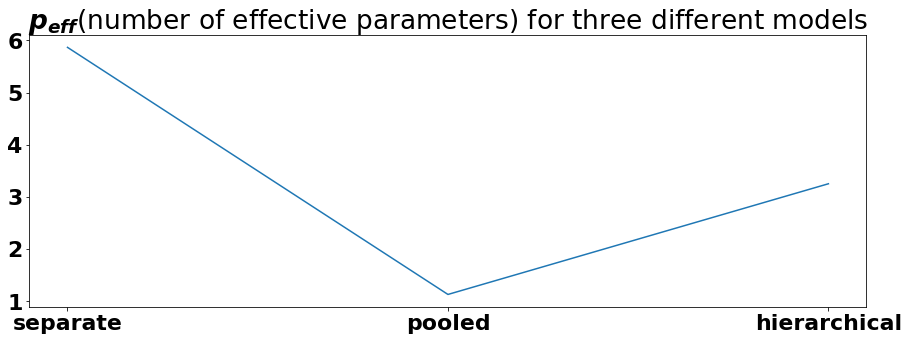

In [30]:
Y = [llpd_separate- loo_separate,llpd_pooled- loo_pooled,llpd_hierarchical- loo_hierarchical]
X = list(range(3))
Xticks = ["separate", 'pooled', "hierarchical"]
plt.figure(figsize=(15,5))
plt.title(r"$p_{eff}$(number of effective parameters) for three different models")
plt.xticks(X, Xticks)
plt.plot(X, Y)

In [31]:
[llpd_separate- loo_separate,llpd_pooled- loo_pooled,llpd_hierarchical- loo_hierarchical]

[5.8657074077480473, 1.1325282740291414, 3.2527028957935187]

/Users/seyoung/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


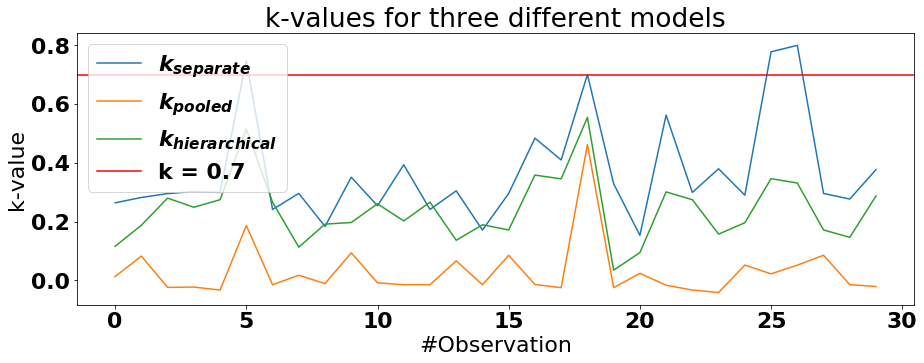

In [32]:
domain = np.arange(len(ks_hierarchical))
plt.figure(figsize=(15,5))
plt.title("k-values for three different models")
plt.xlabel("#Observation")
plt.ylabel("k-value")
plt.plot(domain, ks_separate)
plt.plot(domain, ks_pooled)
plt.plot(domain, ks_hierarchical)
plt.axhline(y=0.7, color='r', linestyle='-', label=r'$k = 0.7$')
plt.legend([r'$k_{separate}$', r'$k_{pooled}$',r'$k_{hierarchical}$','k = 0.7'], loc='upper left')